In [1]:
import matplotlib.pyplot as plt

from utils import *
import plotly.express as px

In [ ]:
!python -m serial.tools.list_ports

# Drift and Hysteresis Analysis

## Measurements

In [ ]:
port = "/dev/ttyUSB0"
df = read_measurements_df(port=port, duration=5, calibration=False)
for i in range(12*30):
    df = pd.concat([df, read_measurements_df(port=port, duration=5, calibration=False)], ignore_index=True)

In [ ]:
df['timestamp'] = df['timestamp'] - df['timestamp'][0]
df.to_csv("data/test_5.csv", index=False)

In [ ]:
df  = pd.read_csv("data/test_5.csv")
fig = px.line(df, x=df.timestamp, y=[f"sensor_{i}" for i in range(1,7)], title='Drift and hysteresis analysis (unmounted)')
fig.write_html('data/test_5.html', auto_open=True)

## Analysis
An approximately 6 min long experiment was made to obtain an initial feeling of the drift and hysteresis from the sensors. This is important to obtain the values of the sensor when the batbot is not mounted, as our goal should be to emulate this sensor values (or use them to calibrate to zero). The experiment (test_5.csv) consisted on manually (literally with the hand) applying force on the 6 axis direction. From the mounted Batbot perspective I will call this axis; front, left, back, right, and down. The forces were applied in this respective order. The forces were applied for approx. 5 seconds and then there were 55 seconds of waiting. This way we can analyse 2 things, is there a considerable drift? Meaning, is there a considerable change in the sensor value from the beginning of a waiting period to the end of it. And are there considerable hysteresis? Which can be calculated through the difference of the sensor value in waiting phase before and after the force application phase. **CAREFUL: The results of this analysis are preliminary, the experiment should be repeated using more realistic forces than my hand pushing and pulling the structure around. For example using real movements of the Batbot.**

In [2]:
df  = pd.read_csv("data/test_5.csv")

First the waiting intervals are manually determined using the pyplot graph as a reference

In [3]:
intervals = {'initial': {'range':(0, 61.5)}, 'post_front': {'range':(70.95, 122.81)}, 'post_left': {'range':(131.53, 181.2)},
             'post_back': {'range':(189.89, 242.21)}, 'post_right': {'range':(250.4, 302.25)}, 'post_up': {'range':(309.78, 362.69)},
             'post_down': {'range':(369.79, 425.58)}}

### Drift

In [5]:
interval_values = {}
for interval in intervals:
    intervals[interval]['values'] = df[(df['timestamp']>intervals[interval]['range'][0])&(df['timestamp']<intervals[interval]['range'][1])].reset_index(drop=True)
    intervals[interval]['drift'] = intervals[interval]['values'].iloc[0] - intervals[interval]['values'].iloc[-1]
    intervals[interval]['mean'] = intervals[interval]['values'].mean().drop('timestamp')
    print(f"Interval {interval} drift:\n {intervals[interval]['drift'].drop('timestamp')}\n")

Interval initial drift:
 sensor_1    0.000136
sensor_2    0.000183
sensor_3    0.000303
sensor_4    0.000084
sensor_5    0.000336
sensor_6    0.000402
dtype: float64

Interval post_front drift:
 sensor_1   -0.001677
sensor_2    0.000021
sensor_3    0.000173
sensor_4    0.000690
sensor_5    0.001121
sensor_6    0.001395
dtype: float64

Interval post_left drift:
 sensor_1    0.000364
sensor_2    0.000411
sensor_3   -0.000239
sensor_4    0.000218
sensor_5   -0.001025
sensor_6    0.000204
dtype: float64

Interval post_back drift:
 sensor_1    0.002257
sensor_2    0.000185
sensor_3    0.000154
sensor_4   -0.000265
sensor_5   -0.000926
sensor_6    0.000213
dtype: float64

Interval post_right drift:
 sensor_1    0.001477
sensor_2   -0.000133
sensor_3    0.000240
sensor_4   -0.000748
sensor_5    0.002617
sensor_6    0.002580
dtype: float64

Interval post_up drift:
 sensor_1    0.000344
sensor_2   -0.000187
sensor_3    0.000101
sensor_4    0.000619
sensor_5    0.001358
sensor_6    0.000172
dtyp

Conclusion: We can see that for a minute-long experiment (which is significantly longer than the 5-15 second experiments I plan to do) the drift is in the 10⁻³ range. Which means that the drift can be neglected.

### Hysteresis

In [6]:
df_sit =[]
for interval in intervals:
    df_sit.append(intervals[interval]['mean'])

df_hist = pd.DataFrame(df_sit)

Considering that the range of the sensor goes from approx. (-4,4)

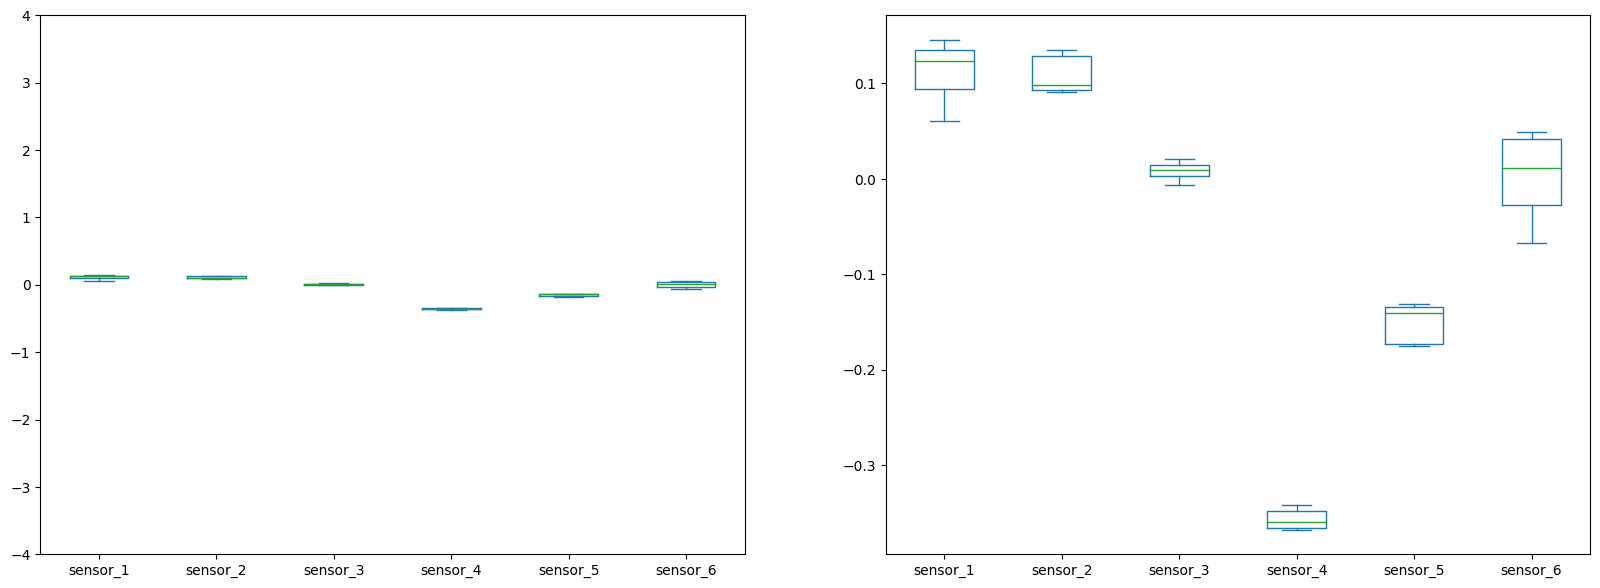

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
df_hist.plot.box(ax=ax1)
ax1.set_ylim((-4,4))

df_hist.plot.box(ax=ax2)
plt.show()

In [27]:
ranges = (df.max(axis=0) - df.min(axis=0)).drop('timestamp')
ranges

sensor_1    3.607101
sensor_2    0.272184
sensor_3    0.186676
sensor_4    6.585256
sensor_5    4.781506
sensor_6    7.908710
dtype: float64

In [29]:
neut_ranges  = df_hist.max(axis=0) - df_hist.min(axis=0)
neut_ranges

sensor_1    0.085533
sensor_2    0.044172
sensor_3    0.027708
sensor_4    0.025881
sensor_5    0.043855
sensor_6    0.116884
dtype: float64

In [30]:
# Percentage maximum error
neut_ranges/ranges

sensor_1    0.023712
sensor_2    0.162286
sensor_3    0.148428
sensor_4    0.003930
sensor_5    0.009172
sensor_6    0.014779
dtype: float64

Conclusion: The range of the distributions obtained from the different sensor reading in neutral state (no force applied) appears to be small. With the largest difference being from the sensor 6 with only a 0.116 max difference. Nevertheless, when taking in consideration that the sensor have different measurements ranges, sensor 3 and 2 have a very large relative difference of 14% and 16% respectively. This is due to the small measurement range of these sensors (0.02 and 0.04). This may be due to the fact that the Batbot is positioned exactly vertically from these sensors (which calculate forces in the horizontal axis). A solution could be to move the Batbot to the center of the sensor positions with respect to the horizontal plane.